In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import seaborn as sns
%matplotlib inline

In [258]:
model = "ViT-L-14"
#model = "ViT-B-32"

nodes = (1,2,4,8,16,32,64,128)

df = pd.read_csv("results.csv")
#df = pd.read_csv("results_rio.csv")

model_pretty = {"ViT-B-32": "CLIP ViT-B/32", "ViT-L-14": "CLIP ViT-L/14"}[model]
model_slug = {"ViT-B-32": "vitb32", "ViT-L-14": "vitl14"}[model]
df['gpus'] = df['gpus_per_node'] * df['nodes']
samples_per_sec_per_gpu = df['samples_per_sec'] / (df['nodes'] * df['gpus_per_node'])
df['secs_per_batch'] = df['local_batch_size'] * (1.0 / samples_per_sec_per_gpu)
df = df[df.model==model]
df = df[df.nodes.isin(nodes)]
df.sort_values(by='gpus')
df

,nodes,gpus_per_node,model,local_batch_size,samples_per_sec,secs_per_batch,dataset,gpus
4,1,6,ViT-L-14,64,298.742162,1.285389,laion400m,6
6,2,6,ViT-L-14,64,595.638206,1.289373,laion400m,12
8,4,6,ViT-L-14,64,1188.804669,1.292054,laion400m,24
12,8,6,ViT-L-14,64,2344.635547,1.310225,laion400m,48
14,16,6,ViT-L-14,64,4627.218146,1.327796,laion400m,96
15,32,6,ViT-L-14,64,8895.641337,1.381351,laion400m,192
17,64,6,ViT-L-14,64,16825.342270,1.460654,laion400m,384


In [259]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scaling_and_efficiency(df, name="ViT", min_node=1, **kw):
    """
    Render scaling and efficiency plots

    - Scaling plot is the relationship between the number of GPUs used
      and the speedup in the throughput
    - Efficiency is the ratio of throughput to ideal reference throughput
    """
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")

    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    reference_samples_per_sec = df.iloc[0]['samples_per_sec']
    # reference throughput is the throughput of the configuration with the reference number of GPUs
    #reference_secs = df.iloc[0]["secs_per_batch"]
    #df["Speedup"] = (reference_secs / df['secs_per_batch']) * df['gpus']
    df["Speedup"] = df["samples_per_sec"] / reference_samples_per_sec
    # efficiency is the  $E(K) = 100 \times \frac{T(K)}{K \times T(1)}$, where:
    # - $K$ is the number of GPUs
    # - $T(K)$ is the throughput for $K$ GPUs
    # - $T(1)$ the reference throughput (for $K=1$)
    #df['efficiency'] =  reference_secs/ df["secs_per_batch"]
    df['efficiency'] =  df["samples_per_sec"] / ( (df['gpus']/refrence_nb_gpus) * reference_samples_per_sec)
    df_raw = df
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.4

    df = df[df.nodes>=min_node]

    # plot
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    y = df['efficiency'] * 100#* scale + top

    ax1.set_ylabel('Efficiency (%)', color='red', fontsize=22)
    ax1.plot(df.GPUs, y, c='red', marker="o", label='efficiency')
    #ax1.plot(cs.gpus, cs.Efficiency, c='green', marker="o", label='efficiency')

    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel('GPUs', fontsize=15)
    
    for nb_gpus, effval, yval in zip(df.GPUs, df['efficiency'], y):
        ax1.text(nb_gpus, yval+text_spacing, f"{effval*100:.2f}%", size=16, c='red')
        
        
    ax2 = ax1.twinx()
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 

    ax2.plot(df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')

    ax2.set_xlabel('GPUs')
    ax2.set_ylabel('Speedup',color='blue', fontsize=22)
    ax2.set_xticks(df.GPUs)
    ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')

    ax2.tick_params(axis='y', labelcolor='blue')
    plt.xlabel("Number of GPUs (V100)")
    plt.legend(loc='upper center', fontsize=22)
    return df_raw

def plot_scaling(df, name="ViT", log=True, min_node=1, **kw):
    df = df.copy()
    # Number of GPUs per run
    df["GPUs"] = df["gpus"]
    df = df.sort_values(by="GPUs")
    # reference number of GPUs is the run with minimal number of GPUs
    refrence_nb_gpus = df.iloc[0]['GPUs']
    reference_samples_per_sec = df.iloc[0]['samples_per_sec']
    df["Speedup"] = df["samples_per_sec"] / reference_samples_per_sec
    df_raw = df
    scale = df.Speedup.max() * 1.5
    top = 0
    text_spacing = 0.4
    df = df[df.nodes>=min_node]
    fig, ax1 = plt.subplots(**kw)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=22) 
    ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
    #ax2.plot(cs.gpus, cs.Speedup, 'go--', label='Speedup (CLIP ViT-B/32)', color='green')
    ax1.yaxis.tick_right()
    
    ax1.set_xlabel('GPUs')
    ax1.set_ylabel('Speedup', fontsize=22)
    ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')
    if log:
        ax1.set_xticks(np.log2(df.GPUs), df.GPUs.apply(str))
    ax1.tick_params(axis='y', labelsize=22)
    plt.xlabel("Number of GPUs (V100)", fontsize=22)
    plt.legend(loc='upper center', fontsize=22)

    return df_raw

def plot_images_per_sec(df, name="ViT", **kw):
    """
    Render raw images per sec plot
    """
    df = df.copy()
    df["GPUs"] = df['gpus']
    df = df.sort_values(by="GPUs")
    df['Samples/s'] = ((df.local_batch_size) / df.secs_per_batch) * df.gpus
    df['Ideal'] = (df.local_batch_size / df.secs_per_batch.iloc[0]) * df.gpus
    fig = plt.figure(**kw)
    #ax= df.plot(x="GPUs",  y="Sample/s", color='pink', edgecolor='red', kind='bar')
    #df.plot(x="GPUs",  y="ideal", color='lightgreen', edgecolor='green', kind='bar',ax=ax)
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 

    plt.bar(df['GPUs'].apply(str), df['Samples/s'], color='pink', edgecolor='red', label=f'Samples/s ({name})')
    plt.bar(df['GPUs'].apply(str), df['Ideal']-df['Samples/s'], color='red', edgecolor='red', bottom=df['Samples/s'], label='Ideal')
    plt.xlabel("Number of GPUs (V100)", fontsize=22)
    
    plt.legend(fontsize=22, loc='best')

/tmp/ipykernel_195769/2528936298.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
/tmp/ipykernel_195769/2528936298.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')


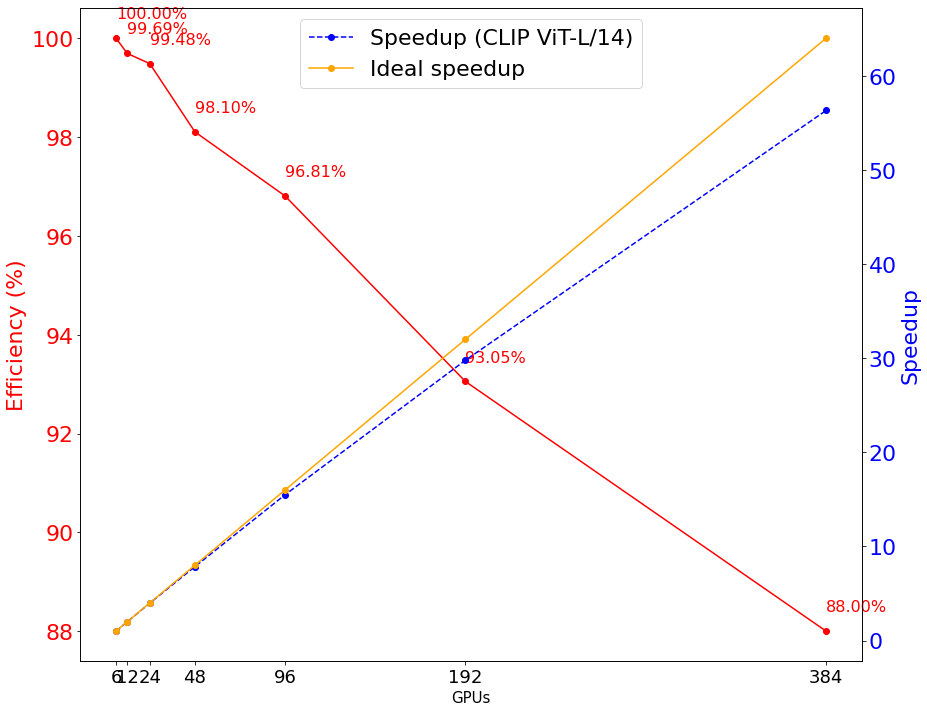

In [260]:
df_ext = plot_scaling_and_efficiency(df, model_pretty, figsize=(14,12), )

/tmp/ipykernel_195769/2528936298.py:90: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.Speedup, 'go--', label=f'Speedup ({name})', color='blue')
/tmp/ipykernel_195769/2528936298.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(np.log2(df.GPUs) if log else df.GPUs, df.GPUs / refrence_nb_gpus, 'go-', label='Ideal speedup', color='orange')


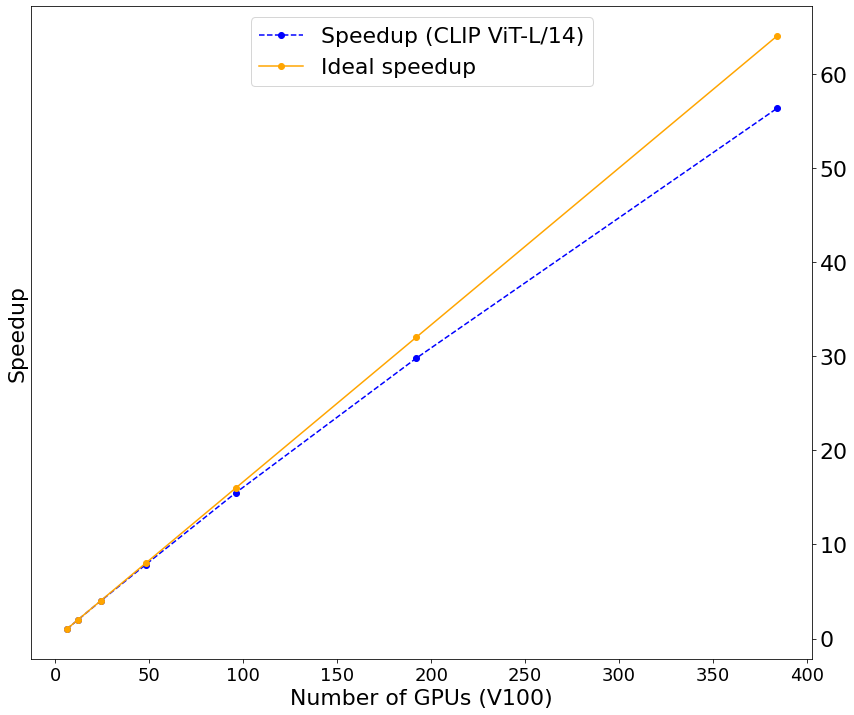

In [261]:
plot_scaling(df, name=model_pretty, figsize=(14,12), log=False)
plt.savefig(f"scaling_efficiency_{model_slug}.pdf")

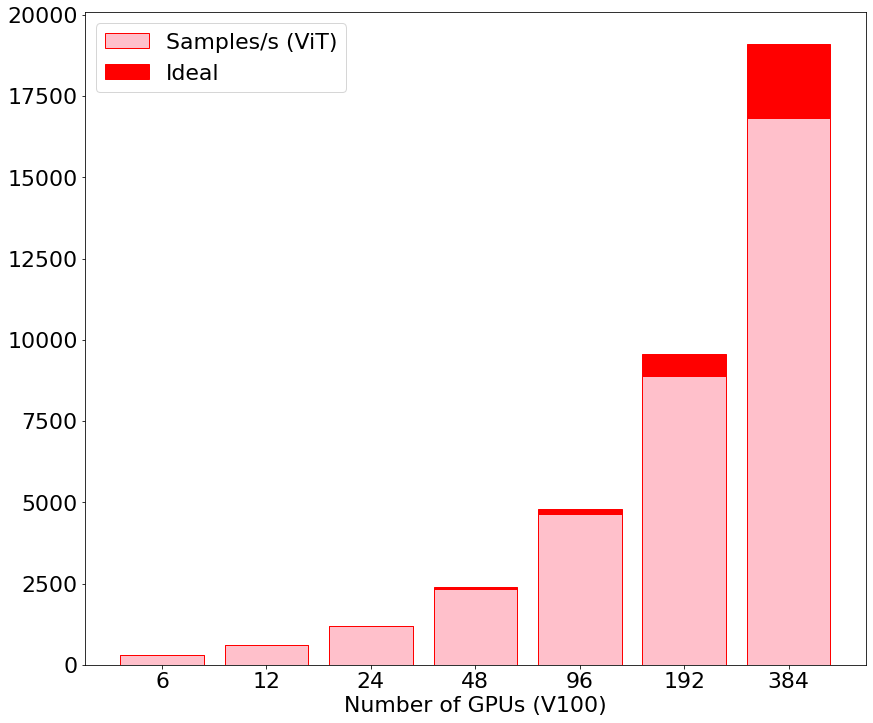

In [262]:
plot_images_per_sec(df, figsize=(14,12))
plt.savefig(f"images_per_sec_{model_slug}.pdf")

In [263]:
def generate_table():
    s = ""
    s += "\\begin{tabular}{@{}ccrr@{}}\n"
    s += "\\toprule\n"
    s += "# Nodes & # GPUs & samples/sec & Efficiency (\\%)" + r"\\" + r"\midrule" + "\n"
    for _, row in df_ext.iterrows():
        s += f"{row.nodes} & {row.gpus_per_node*row.nodes} & {row.samples_per_sec:} & {row.efficiency*100:.2f}\\%"
        s += r"\\"
        s += "\n"
    s += r"\bottomrule"
    s += "\n"
    s += "\\end{tabular}\n"
    return s
print(generate_table())

\begin{tabular}{@{}ccrr@{}}
\toprule
# Nodes & # GPUs & samples/sec & Efficiency (\%)\\\midrule
1 & 6 & 298.7421621928252 & 100.00\%\\
2 & 12 & 595.6382058661953 & 99.69\%\\
4 & 24 & 1188.8046691052873 & 99.48\%\\
8 & 48 & 2344.6355471907477 & 98.10\%\\
16 & 96 & 4627.2181461122855 & 96.81\%\\
32 & 192 & 8895.641337230232 & 93.05\%\\
64 & 384 & 16825.342269678928 & 88.00\%\\
\bottomrule
\end{tabular}

